# Background

We had a morning meeting on February 8th, 2019.  In that meeting Michael wanted the lateral version of the brain as well to show the brain stem if possible.  This notebook just adds that on to the already completed work from this week.

Michael wanted more colour in the gradients so the next step would be to generate a stack with RED->Yellow->Green

Marcus suggested using his [observable notebook](https://beta.observablehq.com/@magfoto/wavelengths-and-spectral-colours) to fine tune the calculations.

# Imports

In [1]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.ndimage
import scipy.misc
from skimage import color, io, img_as_float

gif generation lib

In [3]:
import imageio

# Functions

In [6]:
def getSmoothenImage(img):
    imgSmoothed = SimpleITK.CurvatureFlow(image1=img,
        timeStep=0.125,
        numberOfIterations=5)
    return imgSmoothed

# Parameters

In [8]:
inpath = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Monkey//10 sample Chimpanzee 3T for NCBR website//Male_Fritz.nii'
# inpath = "C://Cerebral//_MarioSandBox//DB//medicalHolography//UofT Mouse Brain//C57brain.mnc"

In [9]:
# Z slice of the DICOM files to process. In the interest of
# simplicity, segmentation will be limited to a single 2D
# image but all processes are entirely applicable to the 3D image
idxSlice = 50

# int labels to assign to the segmented white and gray matter.
# These need to be different integers but their values themselves
# don't matter
labelWhiteMatter = 1
labelGrayMatter = 2

# Reading Data

In [10]:
reader = SimpleITK.ImageFileReader()
image = SimpleITK.ReadImage(inpath)

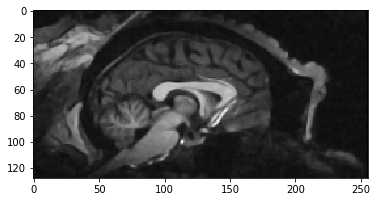

In [54]:
randomSlice = 126
currentSlice = image[randomSlice,:,:]
currentSliceSmoothed = getSmoothenImage(currentSlice)
numpyArraySlice = SimpleITK.GetArrayFromImage(currentSliceSmoothed)
plt.imshow(numpyArraySlice)

# Colour Mapping Variants

## Gradients

In [40]:
numSlices = image.GetWidth()

In [45]:
imageStackNumpy = []
for currentSliceInd in xrange(numSlices):
    currentSlice = image[currentSliceInd,:,:]
    currentSliceSmoothed = getSmoothenImage(currentSlice)
    numpyArraySlice = SimpleITK.GetArrayFromImage(currentSliceSmoothed)
    imageStackNumpy.append(numpyArraySlice)    

Like in the previous notebook entitled "Monkey_CreateGradientColourSlices" to apply a mask I used the following tutorial in a [stackoverflow thread](https://stackoverflow.com/questions/9193603/applying-a-coloured-overlay-to-an-image-in-either-pil-or-imagemagik)

Using Marcus' [observable](https://beta.observablehq.com/@magfoto/wavelengths-and-spectral-colours) we know the following:

1. Red -> Yellow -> Green is the same in RGB as [1,0,0]->[1,1,0]->[0,1,0]
    - notice that the transitino from red to yellow means incrementing the green channel to 1 and from yellow to green the red channel is decrementing to 0.  We will use this observation to perform the transition.
    

2. Incrementing R and G channels means there is a range of 2 units to play with here and since there are numSlices worth of slices we can divide this by 2.  This will get us the incrementing factor.


3.  We also need a threshold at which we switch from incrementing G and decremning R.  There are two possibilities
    - When G reaches 1 decrement R
    - When we have gone through half the slices we decrement R
        - This option is better as we can reuse old code

In [46]:
alpha = 1.0
rgChannelRange = 2.0
th = numSlices/2.0
incrementalFactor = rgChannelRange/numSlices
decrementalFactor = rgChannelRange/numSlices

In [48]:
maskedImage = []
rChannel = 1.0
gChannel = 0.0
bChannel = 0.0

for sliceInd in xrange(numSlices):
    
        
    # get the image
    imgRaw = imageStackNumpy[sliceInd]
    if(imgRaw.max()==0):
        img = imgRaw/0.000001
    else:
        img = imgRaw/imgRaw.max()
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    
    # contruct colour image to superimpose
    color_mask[0:rows-1, 0:cols-1] = [rChannel, gChannel, bChannel]  # Red block
#     print("[{},{},{}]".format(rChannel, gChannel, bChannel))
          
    if(sliceInd<th):                     
        gChannel = gChannel+incrementalFactor
    else:
        rChannel = rChannel-decrementalFactor       
    
    
    # Construct RGB version of grey-level image
    img_color = np.dstack((img, img, img))
    
    # Convert the input image and color mask to Hue Saturation Value (HSV)
    # colorspace
    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    # Replace the hue and saturation of the original image
    # with that of the color mask
    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    
    maskedImage.append(img_masked)

In [ ]:
plt.figure(32)

plt.subplot(1,3,1)
randomSlice = 126
currentSlice = image[randomSlice,:,:]
currentSliceSmoothed = getSmoothenImage(currentSlice)
numpyArraySlice = SimpleITK.GetArrayFromImage(currentSliceSmoothed)
plt.imshow(numpyArraySlice)
plt.title('Random Red Slice')

plt.subplot(1,3,2)
randomSlice = 126
currentSlice = image[randomSlice,:,:]
currentSliceSmoothed = getSmoothenImage(currentSlice)
numpyArraySlice = SimpleITK.GetArrayFromImage(currentSliceSmoothed)
plt.imshow(numpyArraySlice)
plt.title('Random Yellow Slice')

plt.subplot(1,3,3)
randomSlice = 126
currentSlice = image[randomSlice,:,:]
currentSliceSmoothed = getSmoothenImage(currentSlice)
numpyArraySlice = SimpleITK.GetArrayFromImage(currentSliceSmoothed)
plt.imshow(numpyArraySlice)
plt.title('Random Green Slice')

plt.show

# Gif Generation

In [50]:
dirGifOutput = "C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//gifs//"

## With Gradient Colour

In [51]:
imageio.mimsave(dirGifOutput+'fritzGradientRYG_Lateral\.gif',maskedImage)

# Image Stack Generation

In [52]:
imageStackOutFile = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Stacks - Colour Gradients RYG Lateral View//'

In [53]:
for sliceInd in xrange(numSlices):
    imageio.imwrite(imageStackOutFile + '{}.jpg'.format(sliceInd), maskedImage[sliceInd])